# Работа над построением модели прогнозирования температуры на будущий день для Акселерационной программы

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import requests

### Задаем параметры для подключения к API meteostat.net для получения данных с Питерской метео-станции

In [123]:
api_key = '48aaef5c1amsh742439722462139p1c30d6jsn6d124ab21f82'

url = 'https://meteostat.p.rapidapi.com/stations/daily'

params = {
    'station': '26063',
    'start': '2015-01-01',
    'end': '2024-11-01'
}

headers = {
    'x-rapidapi-host': 'meteostat.p.rapidapi.com',
    'x-rapidapi-key': api_key
}

### Отправляем запрос и записываем ответ в переменную

In [124]:
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()
else:
    print(f"Ошибка: {response.status_code}")

### Запишем ответ в pd.DataFrame для более удобного взаимодействия и добавим целевую переменную - температуру на следующий день

In [125]:
df = pd.DataFrame(data['data'])
next_day_tavg = df['tavg'][1:]
next_day_tavg.reset_index(drop=True, inplace=True)
df.drop(index=[df.shape[0]-1], inplace=True)
df['next_day_tavg'] = next_day_tavg
df

,date,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,next_day_tavg
0,2015-01-01,2.2,0.5,3.0,0.1,NaN,263.0,14.9,NaN,NaN,None,2.7
1,2015-01-02,2.7,1.7,3.8,7.9,10.0,230.0,14.7,NaN,NaN,None,1.2
2,2015-01-03,1.2,0.5,3.9,9.2,10.0,256.0,23.9,NaN,NaN,None,-3.9
3,2015-01-04,-3.9,-5.9,0.5,2.1,30.0,330.0,18.0,NaN,NaN,None,-8.3
4,2015-01-05,-8.3,-9.2,-5.8,1.2,51.0,11.0,16.1,NaN,NaN,None,-10.9
...,...,...,...,...,...,...,...,...,...,...,...,...
3587,2024-10-27,7.7,6.0,10.3,0.0,NaN,157.0,8.8,22.2,1019.9,None,8.7
3588,2024-10-28,8.7,7.0,11.0,3.2,NaN,223.0,16.9,33.3,1010.4,None,5.0
3589,2024-10-29,5.0,3.0,7.9,0.0,NaN,266.0,13.0,29.6,1014.5,None,6.6
3590,2024-10-30,6.6,3.0,9.4,2.9,NaN,251.0,22.1,46.3,1001.0,None,3.6


# Проведем разведочный анализ для выявления закономерностей и обработки данных от пустых значений

### Проверим типы данных

In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3592 entries, 0 to 3591
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           3592 non-null   object 
 1   tavg           3592 non-null   float64
 2   tmin           3592 non-null   float64
 3   tmax           3592 non-null   float64
 4   prcp           3408 non-null   float64
 5   snow           833 non-null    float64
 6   wdir           3175 non-null   float64
 7   wspd           3585 non-null   float64
 8   wpgt           2295 non-null   float64
 9   pres           3154 non-null   float64
 10  tsun           0 non-null      object 
 11  next_day_tavg  3592 non-null   float64
dtypes: float64(10), object(2)
memory usage: 336.9+ KB


### Объект даты имеет строковый тип, преобразуем его и разобъем на категориальные переменные для дальнейшего использования при обучении

In [127]:
df.date = pd.to_datetime(df['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3592 entries, 0 to 3591
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           3592 non-null   datetime64[ns]
 1   tavg           3592 non-null   float64       
 2   tmin           3592 non-null   float64       
 3   tmax           3592 non-null   float64       
 4   prcp           3408 non-null   float64       
 5   snow           833 non-null    float64       
 6   wdir           3175 non-null   float64       
 7   wspd           3585 non-null   float64       
 8   wpgt           2295 non-null   float64       
 9   pres           3154 non-null   float64       
 10  tsun           0 non-null      object        
 11  next_day_tavg  3592 non-null   float64       
dtypes: datetime64[ns](1), float64(10), object(1)
memory usage: 336.9+ KB


In [128]:
df['day'] = df.date.dt.day.astype('category')
df['month'] = df.date.dt.month.astype('category')
df.drop(columns=['date'], inplace=True)
df

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,next_day_tavg,day,month
0,2.2,0.5,3.0,0.1,NaN,263.0,14.9,NaN,NaN,None,2.7,1,1
1,2.7,1.7,3.8,7.9,10.0,230.0,14.7,NaN,NaN,None,1.2,2,1
2,1.2,0.5,3.9,9.2,10.0,256.0,23.9,NaN,NaN,None,-3.9,3,1
3,-3.9,-5.9,0.5,2.1,30.0,330.0,18.0,NaN,NaN,None,-8.3,4,1
4,-8.3,-9.2,-5.8,1.2,51.0,11.0,16.1,NaN,NaN,None,-10.9,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3587,7.7,6.0,10.3,0.0,NaN,157.0,8.8,22.2,1019.9,None,8.7,27,10
3588,8.7,7.0,11.0,3.2,NaN,223.0,16.9,33.3,1010.4,None,5.0,28,10
3589,5.0,3.0,7.9,0.0,NaN,266.0,13.0,29.6,1014.5,None,6.6,29,10
3590,6.6,3.0,9.4,2.9,NaN,251.0,22.1,46.3,1001.0,None,3.6,30,10


### Теперь займемся обработкой пустых значений, заглянем в документацию к api для расшифровки сокращений
![](api_description.png)

In [129]:
df.isnull().sum()

tavg                0
tmin                0
tmax                0
prcp              184
snow             2759
wdir              417
wspd                7
wpgt             1297
pres              438
tsun             3592
next_day_tavg       0
day                 0
month               0
dtype: int64

### Удалим строки с отсутствующими значениями скорости ветра

In [130]:
df.drop(index=df[df.wspd.isnull()].index, inplace=True)
df.isnull().sum()

tavg                0
tmin                0
tmax                0
prcp              184
snow             2754
wdir              410
wspd                0
wpgt             1290
pres              434
tsun             3585
next_day_tavg       0
day                 0
month               0
dtype: int64

### Очень интересно посмотреть на распределение направлений ветра. Так как оно циклично и значения будут плохо интерпритируемы моделью, скорее всего придется заменить их на категории. Также в них есть пропуски, поэтому надо придумать чем их заполнить.

C:\Users\Vladimir\Documents\ML\anacondas\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


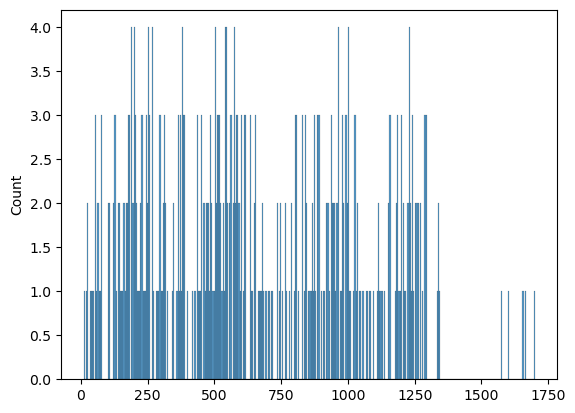

In [131]:
no_direction = df[df.wdir.isnull()]
sns.histplot(x=no_direction.index, bins=400);

### Из разговора с Метеорологом (Полиной) ясно, что направление ветра имеет важное значение в показателе температуры. В то же время пропуски не распределены по выборке равномерно, что не дает нам воспользоваться интерполяцией. Как бы это не было прискорбно, пропуски придется удалить

In [132]:
df.drop(index=df[df.wdir.isnull()].index, inplace=True)
df.isnull().sum()

tavg                0
tmin                0
tmax                0
prcp              184
snow             2428
wdir                0
wspd                0
wpgt              889
pres              317
tsun             3175
next_day_tavg       0
day                 0
month               0
dtype: int64

### Теперь преобразуем направления ветра в категории для корректной интерпритации этого параметра моделью

In [133]:
def conversion(direction):
    if 22.5 <= direction < 67.5:
        return 'NE'
    if 67.5 <= direction < 112.5:
        return 'E'
    if 112.5 <= direction < 157.5:
        return 'SE'
    if 157.5 <= direction < 202.5:
        return 'S'
    if 202.5 <= direction < 247.5:
        return 'SW'
    if 247.5 <= direction < 292.5:
        return 'W'
    if 292.5 <= direction < 237.5:
        return 'NW'
    return 'N'

df.wdir = df.wdir.apply(conversion)
df

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,next_day_tavg,day,month
0,2.2,0.5,3.0,0.1,NaN,W,14.9,NaN,NaN,None,2.7,1,1
1,2.7,1.7,3.8,7.9,10.0,SW,14.7,NaN,NaN,None,1.2,2,1
2,1.2,0.5,3.9,9.2,10.0,W,23.9,NaN,NaN,None,-3.9,3,1
3,-3.9,-5.9,0.5,2.1,30.0,N,18.0,NaN,NaN,None,-8.3,4,1
4,-8.3,-9.2,-5.8,1.2,51.0,N,16.1,NaN,NaN,None,-10.9,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3587,7.7,6.0,10.3,0.0,NaN,SE,8.8,22.2,1019.9,None,8.7,27,10
3588,8.7,7.0,11.0,3.2,NaN,SW,16.9,33.3,1010.4,None,5.0,28,10
3589,5.0,3.0,7.9,0.0,NaN,W,13.0,29.6,1014.5,None,6.6,29,10
3590,6.6,3.0,9.4,2.9,NaN,W,22.1,46.3,1001.0,None,3.6,30,10


In [134]:
df.wdir = df.wdir.astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3175 entries, 0 to 3591
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   tavg           3175 non-null   float64 
 1   tmin           3175 non-null   float64 
 2   tmax           3175 non-null   float64 
 3   prcp           2991 non-null   float64 
 4   snow           747 non-null    float64 
 5   wdir           3175 non-null   category
 6   wspd           3175 non-null   float64 
 7   wpgt           2286 non-null   float64 
 8   pres           2858 non-null   float64 
 9   tsun           0 non-null      object  
 10  next_day_tavg  3175 non-null   float64 
 11  day            3175 non-null   category
 12  month          3175 non-null   category
dtypes: category(3), float64(9), object(1)
memory usage: 283.7+ KB


### Параметр wpgt (пиковая скорость) не несет в себе мощной смысловой нагрузки, так как присутсвует параметр wspd (средняя скорость), а также имеет кучу пропусков.
### Забавно, что параметр tsun (количество солнычных минут) и вовсе не отслеживается. Удалим эти колонки за ненадобностью

In [135]:
df.drop(columns=['wpgt', 'tsun'], inplace=True)
df.isnull().sum()

tavg                0
tmin                0
tmax                0
prcp              184
snow             2428
wdir                0
wspd                0
pres              317
next_day_tavg       0
day                 0
month               0
dtype: int64

### Займемся давлением: построим распределение

C:\Users\Vladimir\Documents\ML\anacondas\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Vladimir\Documents\ML\anacondas\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


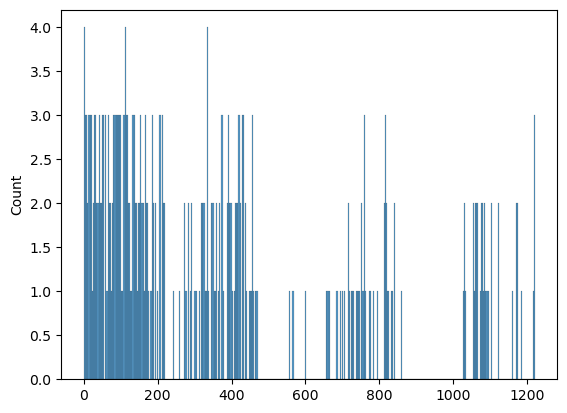

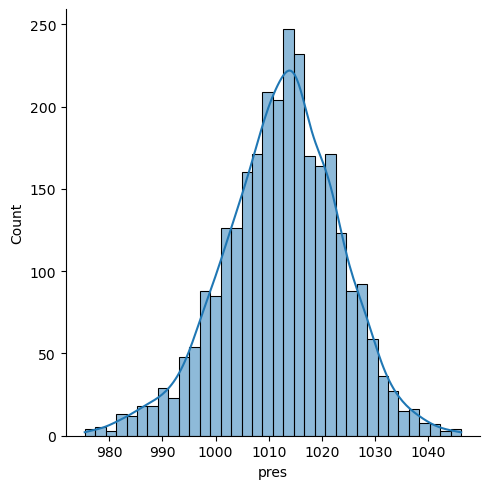

In [136]:
no_pres = df[df.pres.isnull()]
sns.histplot(x=no_pres.index, bins=400);
sns.displot(data=df.pres, kde=True);

### Пропуски лежат в начале выборки. Найдем интервал, в котором лежит 90% показателей

In [137]:
lower_bound = np.percentile(df.pres.dropna(), 5)
upper_bound = np.percentile(df.pres.dropna(), 95)
lower_bound, upper_bound

(993.885, 1029.5)

### Интервал мал, Полина дала добро на замену пустых значений средним

In [138]:
mean = df.pres.mean()
df['pres'].fillna(value=mean, inplace=True)

### Оставшиеся переменные, в соответствии с описанием данных, имеют пропуски из-за отсутствия осадков. Это дает нам право заменить пропуски на ноль.

In [139]:
df[['prcp', 'snow']] = df[['prcp', 'snow']].fillna(0)
df.isnull().sum()

tavg             0
tmin             0
tmax             0
prcp             0
snow             0
wdir             0
wspd             0
pres             0
next_day_tavg    0
day              0
month            0
dtype: int64

### Заменим категории на дамми-переменные

In [140]:
categorical_columns = ['wdir', 'day', 'month']

df_dummies = pd.get_dummies(df[categorical_columns], drop_first=True)
df = pd.concat([df, df_dummies], axis=1)
df.drop(columns=categorical_columns, inplace=True)

In [141]:
df

,tavg,tmin,tmax,prcp,snow,wspd,pres,next_day_tavg,wdir_N,wdir_NE,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2.2,0.5,3.0,0.1,0.0,14.9,1012.464906,2.7,False,False,...,False,False,False,False,False,False,False,False,False,False
1,2.7,1.7,3.8,7.9,10.0,14.7,1012.464906,1.2,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1.2,0.5,3.9,9.2,10.0,23.9,1012.464906,-3.9,False,False,...,False,False,False,False,False,False,False,False,False,False
3,-3.9,-5.9,0.5,2.1,30.0,18.0,1012.464906,-8.3,True,False,...,False,False,False,False,False,False,False,False,False,False
4,-8.3,-9.2,-5.8,1.2,51.0,16.1,1012.464906,-10.9,True,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3587,7.7,6.0,10.3,0.0,0.0,8.8,1019.900000,8.7,False,False,...,False,False,False,False,False,False,False,True,False,False
3588,8.7,7.0,11.0,3.2,0.0,16.9,1010.400000,5.0,False,False,...,False,False,False,False,False,False,False,True,False,False
3589,5.0,3.0,7.9,0.0,0.0,13.0,1014.500000,6.6,False,False,...,False,False,False,False,False,False,False,True,False,False
3590,6.6,3.0,9.4,2.9,0.0,22.1,1001.000000,3.6,False,False,...,False,False,False,False,False,False,False,True,False,False


### Построим карту корреляции для выявления зависимостей в данных

In [142]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3175 entries, 0 to 3591
Data columns (total 55 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   tavg           3175 non-null   float64
 1   tmin           3175 non-null   float64
 2   tmax           3175 non-null   float64
 3   prcp           3175 non-null   float64
 4   snow           3175 non-null   float64
 5   wspd           3175 non-null   float64
 6   pres           3175 non-null   float64
 7   next_day_tavg  3175 non-null   float64
 8   wdir_N         3175 non-null   bool   
 9   wdir_NE        3175 non-null   bool   
 10  wdir_S         3175 non-null   bool   
 11  wdir_SE        3175 non-null   bool   
 12  wdir_SW        3175 non-null   bool   
 13  wdir_W         3175 non-null   bool   
 14  day_2          3175 non-null   bool   
 15  day_3          3175 non-null   bool   
 16  day_4          3175 non-null   bool   
 17  day_5          3175 non-null   bool   
 18  day_6        

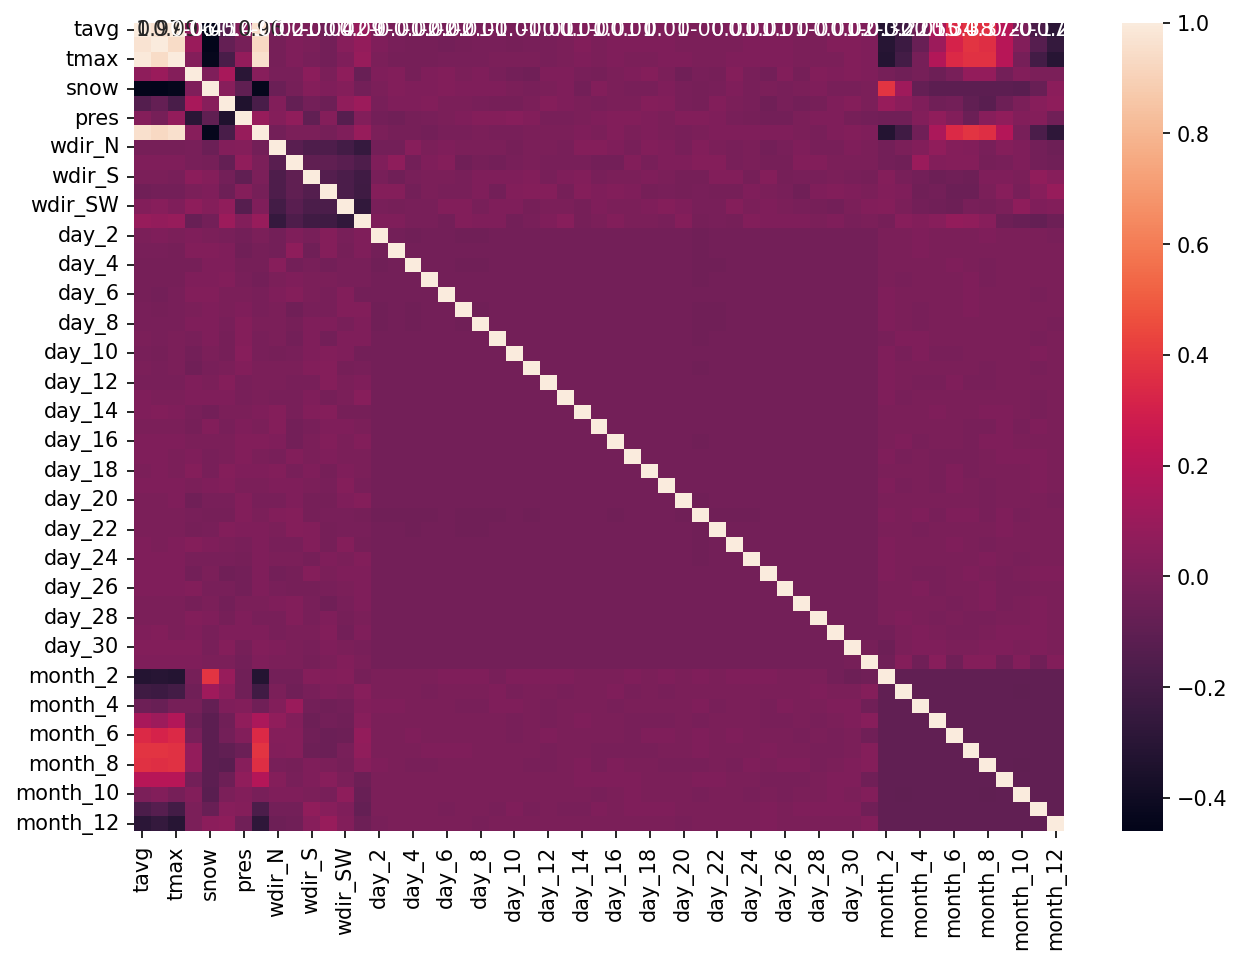

In [143]:
plt.figure(figsize=(10, 7), dpi=150)
weather_corr = df.corr(numeric_only=True).round(2)
sns.heatmap(data=weather_corr, annot=True);

### Заметна несущественная корреляция целевой переменной (next_day_tavg) с большинством независимых переменных, однако в будущем при расширении полинома они еще себя проявят, а если нет, то регуляризация все исправит за нас

# Приступим к написанию модели

### Импортируем модули для МО

In [23]:
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

### Разобьем данные на 2 части - целевой вектор и матрица признаков

In [24]:
next_temp = df['next_day_tavg']
features = df.drop(columns=['next_day_tavg'])

### Напишем функцию для визуализации ошибок, для добавления комбинации признаков путем поднятия степени полинома и стандартизации данных

In [113]:
# poly_converter = 0
# scaler = 0

In [117]:
def convert_into_poly(deg: int, features: pd.DataFrame):
    global poly_converter
    global scaler
    poly_converter = PolynomialFeatures(degree=deg, include_bias=False)
    scaler = StandardScaler()
    features = scaler.fit_transform(features)
    poly_features = pd.DataFrame(poly_converter.fit_transform(features), columns=poly_converter.get_feature_names_out())
    return poly_features

In [26]:
def visualization(tests):
    plt.plot(np.arange(1, len(tests[0]) + 1), tests[0], label='mean_test')
    plt.plot(np.arange(1, len(tests[1]) + 1), tests[1], label='mean_train')
    plt.plot(np.arange(1, len(tests[2]) + 1), tests[2], label='abs_test')
    plt.plot(np.arange(1, len(tests[3]) + 1), tests[3], label='abs_train')
    plt.legend();

## Теперь попробуем каждый из видов регрессии и поиграемся со степенями полинома для выявления победителя

## Начнем с Lasso (L1)

0.008955502203248377
0.08141097768918777
0.15021931189420318


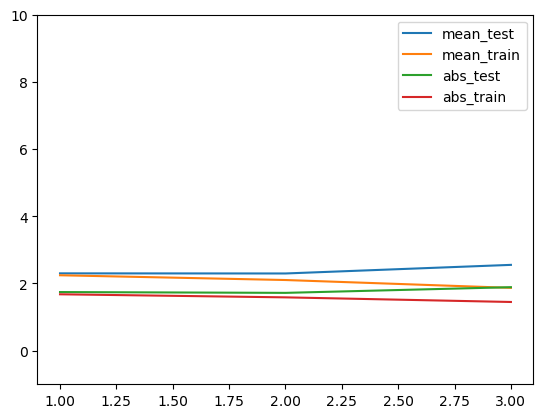

In [68]:
mean_error_test = []
mean_error_train = []
abs_error_test = []
abs_error_train = []
for i in range(1, 4):
    poly_features = convert_into_poly(i, features)
    X_train, X_test, y_train, y_test = train_test_split(poly_features, next_temp, test_size=0.3, random_state=100)

    model = LassoCV()
    model.fit(X_train, y_train)
    print(model.alpha_)
    

    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    mean_error_test.append(mean_squared_error(y_test, y_pred) ** 0.5)
    mean_error_train.append(mean_squared_error(y_train, y_pred_train) ** 0.5)
    abs_error_test.append(mean_absolute_error(y_test, y_pred))
    abs_error_train.append(mean_absolute_error(y_train, y_pred_train))
tests = [mean_error_test, mean_error_train, abs_error_test, abs_error_train]
visualization(tests)
plt.ylim([-1, 10]);

### Очевидно, что переобучение начинается с третей степени полинома. Результат ожидаемый, так как при полиноме 3-й степени число признаков превосходит число наблюдений. В дальнейших тестах будем считать 2-ю степень за константу.
### Добавим настройки для поиска альфа значение и уберем random_state чтобы проверить модель на разных вариациях выборки

In [73]:
mean_error_test = []
mean_error_train = []
abs_error_test = []
abs_error_train = []
    
poly_features = convert_into_poly(2, features)
X_train, X_test, y_train, y_test = train_test_split(poly_features, next_temp, test_size=0.3)

model = LassoCV(eps=10 ** -4, n_alphas=60, max_iter=10000, cv=5)
model.fit(X_train, y_train)
    

y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)
mean_error_test.append(mean_squared_error(y_test, y_pred) ** 0.5)
mean_error_train.append(mean_squared_error(y_train, y_pred_train) ** 0.5)
abs_error_test.append(mean_absolute_error(y_test, y_pred))
abs_error_train.append(mean_absolute_error(y_train, y_pred_train))

print(f'MSE test {sum(mean_error_test) / len(mean_error_test)}',
      f'MAE test {sum(abs_error_test) / len(abs_error_test)}',
      sep='\n'
)

MSE test 2.3008027077858504
MAE test 1.7396674236118121


### Средняя ошибка прогноза составляет около 2 градусов. Однако нужно также проверить и остальные модели

## Ridge (L2)

In [79]:
mean_error_test = []
mean_error_train = []
abs_error_test = []
abs_error_train = []
poly_features = convert_into_poly(2, features)
X_train, X_test, y_train, y_test = train_test_split(poly_features, next_temp, test_size=0.3)

model = RidgeCV(alphas=(np.arange(150, 450)))
model.fit(X_train, y_train)
print(model.alpha_)

y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)
mean_error_test.append(mean_squared_error(y_test, y_pred) ** 0.5)
mean_error_train.append(mean_squared_error(y_train, y_pred_train) ** 0.5)
abs_error_test.append(mean_absolute_error(y_test, y_pred))
abs_error_train.append(mean_absolute_error(y_train, y_pred_train))

print(f'MSE test {sum(mean_error_test) / len(mean_error_test)}',
      f'MAE test {sum(abs_error_test) / len(abs_error_test)}',
      sep='\n'
)

277
MSE test 2.56433056746298
MAE test 1.9732865857200883


## ElasticNet (L1+L2)

In [81]:
mean_error_test = []
mean_error_train = []
abs_error_test = []
abs_error_train = []
poly_features = convert_into_poly(2, features)
X_train, X_test, y_train, y_test = train_test_split(poly_features, next_temp, test_size=0.3)

model = ElasticNetCV(eps=10 ** -4, n_alphas=60, max_iter=10000, cv=5, l1_ratio=[.1, .5, .7, .9, .95, 1])
model.fit(X_train, y_train)
print(model.alpha_, model.l1_ratio_)

y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)
mean_error_test.append(mean_squared_error(y_test, y_pred) ** 0.5)
mean_error_train.append(mean_squared_error(y_train, y_pred_train) ** 0.5)
abs_error_test.append(mean_absolute_error(y_test, y_pred))
abs_error_train.append(mean_absolute_error(y_train, y_pred_train))

print(f'MSE test {sum(mean_error_test) / len(mean_error_test)}',
      f'MAE test {sum(abs_error_test) / len(abs_error_test)}',
      sep='\n'
)

0.08535872753938549 1.0
MSE test 2.2400002105002814
MAE test 1.6912403063128207


### Все регуляризаторы выдают примерно одинаковые показатели, однако Эластичная Сеть работает на порядок дольше, по итогам отдавая полный приоритет одному из регуляризаторов. Пожалуй, уберем его из дальнейшего контеста

### В качестве метрики для оценки каждого из регуляризаторов скопируем код, прогоним его несколько раз и посчитаем среднее значение средних ошибок

### Lasso (L1)

In [82]:
mean_error_test = []
mean_error_train = []
abs_error_test = []
abs_error_train = []
poly_features = convert_into_poly(2, features)
X_train, X_test, y_train, y_test = train_test_split(poly_features, next_temp, test_size=0.3)
for i in range(10):
    model = LassoCV(eps=10 ** -4, n_alphas=60, max_iter=10000, cv=5)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    mean_error_test.append(mean_squared_error(y_test, y_pred) ** 0.5)
    mean_error_train.append(mean_squared_error(y_train, y_pred_train) ** 0.5)
    abs_error_test.append(mean_absolute_error(y_test, y_pred))
    abs_error_train.append(mean_absolute_error(y_train, y_pred_train))
    tests = [mean_error_test, mean_error_train, abs_error_test, abs_error_train]
print(f'MSE test {sum(mean_error_test) / len(mean_error_test)}',
      f'MAE test {sum(abs_error_test) / len(abs_error_test)}',
      sep='\n'
)

MSE test 2.2663302211449943
MAE test 1.6546388311049092


### Ridge (L2)

In [84]:
mean_error_test = []
mean_error_train = []
abs_error_test = []
abs_error_train = []
poly_features = convert_into_poly(2, features)
X_train, X_test, y_train, y_test = train_test_split(poly_features, next_temp, test_size=0.3)
for i in range(10):
    model = RidgeCV(alphas=(np.arange(150, 450)))
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    mean_error_test.append(mean_squared_error(y_test, y_pred) ** 0.5)
    mean_error_train.append(mean_squared_error(y_train, y_pred_train) ** 0.5)
    abs_error_test.append(mean_absolute_error(y_test, y_pred))
    abs_error_train.append(mean_absolute_error(y_train, y_pred_train))
    tests = [mean_error_test, mean_error_train, abs_error_test, abs_error_train]
print(f'MSE test {sum(mean_error_test) / len(mean_error_test)}',
      f'MAE test {sum(abs_error_test) / len(abs_error_test)}',
      sep='\n'
)

MSE test 2.6858108906605587
MAE test 2.0437671444168513


## В итоге лучшей моделью оказалась линейная модель с L1 регуляризатором. 
### Обучим модель на всех данных

In [118]:
poly_features = convert_into_poly(2, features)

final_model = LassoCV(eps=10 ** -4, n_alphas=60, max_iter=10000, cv=5)
final_model.fit(poly_features, next_temp)

LassoCV(cv=5, eps=0.0001, max_iter=10000, n_alphas=60)

### Сохраним модель и преобразователи

In [169]:
from sklearn.pipeline import Pipeline
from joblib import dump, load

pipeline = Pipeline([
    ('scaler', scaler),
    ('poly', poly_converter),
    ('model', final_model)
])

dump(pipeline, 'weather_pipeline.joblib')

['weather_pipeline.joblib']

### Попробуем составить прогноз основываясь на вчерашних данных и сравить результат с прогнозом погоды от метеорологов

In [154]:
df_today = df.iloc[1488]
df_yesterday = df.iloc[1489]
df_today = df_today.drop(index=['next_day_tavg'])
y = df_yesterday.tavg

In [173]:
# df_today = df_today.to_numpy()
df_today = df_today.reshape(1, -1)
y_predict = load('weather_pipeline.joblib').predict(df_today)
abs(y - y_predict[0])

C:\Users\Vladimir\Documents\ML\anacondas\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Vladimir\Documents\ML\anacondas\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LassoCV was fitted with feature names
  warnings.warn(


0.9333438995408339

In [157]:
features

,tavg,tmin,tmax,prcp,snow,wspd,pres,wdir_N,wdir_NE,wdir_S,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2.2,0.5,3.0,0.1,0.0,14.9,1012.464906,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,2.7,1.7,3.8,7.9,10.0,14.7,1012.464906,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1.2,0.5,3.9,9.2,10.0,23.9,1012.464906,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,-3.9,-5.9,0.5,2.1,30.0,18.0,1012.464906,True,False,False,...,False,False,False,False,False,False,False,False,False,False
4,-8.3,-9.2,-5.8,1.2,51.0,16.1,1012.464906,True,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3587,7.7,6.0,10.3,0.0,0.0,8.8,1019.900000,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3588,8.7,7.0,11.0,3.2,0.0,16.9,1010.400000,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3589,5.0,3.0,7.9,0.0,0.0,13.0,1014.500000,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3590,6.6,3.0,9.4,2.9,0.0,22.1,1001.000000,False,False,False,...,False,False,False,False,False,False,False,True,False,False
